In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data 6

In [2]:
# Read in
df6 = pd.read_csv('../data/df6.csv')

In [8]:
# Inspect
df6.head()

,x,y
0,2.218651,1.184560
1,2.906897,3.216393
2,3.057199,3.676579
3,3.138405,2.588413
4,3.076162,1.272983


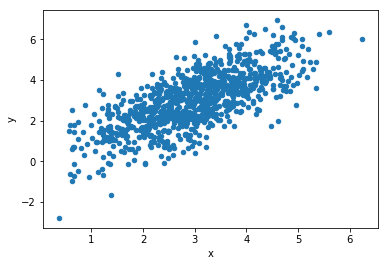

In [4]:
# Plot
df6.plot('x', 'y', kind='scatter')

In [5]:
# Data looks straight-forward.  Fit a simple model again
model6 = smf.ols(
    formula='y ~ x',
    data=df6
)
model6_fit = model6.fit()

C:\Users\Kenneth\Miniconda3\envs\clearbrain_lastresort\lib\site-packages\statsmodels\base\data.py:480: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if hasattr(x, 'ix'):


In [6]:
# Summarize
model6_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     944.2
Date:                Wed, 27 May 2020   Prob (F-statistic):          2.86e-142
Time:                        21:59:02   Log-Likelihood:                -1248.8
No. Observations:                 900   AIC:                             2502.
Df Residuals:                     898   BIC:                             2511.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0718      0.100      0.718      0.473      -0.124       0.268
x              0.9851      0.032     30.728      0.000       0.922       1.048
==============================================================================
Omnibus:                        1.083   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                1.101
Skew:                          -0.084   Prob(JB):                        0.577
Kurtosis:                       2.968   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only 900 rows in the regression, was that everything?

In [9]:
df6.shape

(1000, 2)

Nope, must be null values.  In Python, these are usually np.NaN values but be careful because they could take other values as well.

In [13]:
# See if any np.NaNs
df6[df6['x'].isnull()].head()

,x,y
5,NaN,-1.738836
8,NaN,-2.859447
31,NaN,-0.802285
66,NaN,0.105282
68,NaN,-2.081959


In [14]:
# How many of these?
df6[df6['x'].isnull()].shape

(100, 2)

Looks like these are to blame, because statsmodels does not handle them natively.  Here we are at an important crossroads and need to answer this question: **Do we care about these missing x values?**

- If yes, then we need to find a way to model them.  There are a number of ways to do this, including but not limited to:
    - Fit two separate models, one for nulls and one for non-nulls  
    - Find a clever way to incorporate them into a single regression (which is obviously what we're going to choose here)
- If no, then we can simply filter them out.  But in Derek's opinion you should very rarely do this because this "missingness" usually means something like important, such as an error in the data collection or data aggregation/merging process.

Here, let's include them and find a way to be clever.  Let's define what an interpretable regression formula could look like.  Without nulls, we have something like this

```
y_est = Intercept + B_1 * x
```

And since we only have one variable, it would nice to be able to measure the "effect" of having a missing `x` value.  Which means we need to have an indicator of `x` being missing:

```
y_est = Intercept + B_1 * x + B_2 * (x is null)
```

That indicator is easy to define, but what `x` value do we assign them.  One option is to assign them a value not in the range of our `x` values, like -99, to make the extemely obvious.  This means that, for missing `x` values, the model translates to this:

```
y_est = Intercept + B_1 * -99 + B_2
```

Which, frankly, is not directly intuitive unless you can quickly do that math in your head.  However, what if instead we set x to be 0 when `x` is null?  Unfortunately this overlaps close to non-null `x` values, but makes the regression much more directly interpretable:

```
y_est = Intercept + B_1 * 0 + B_2
y_est = Intercept           + B_2
```

I.e. `B_2` is the average effect if `x` is null.

Let's code it up.

In [20]:
def make_x_0_if_null(x):
    return [0 if np.isnan(a) else a for a in x]

def create_x_null_ind(x):
    return [0 if np.isnan(a) else 1 for a in x]

In [21]:
# Fit model
model6_x_null_ind = smf.ols(
    formula='y ~ make_x_0_if_null(x) + create_x_null_ind(x)',
    data=df6
)
model6_x_null_ind_fit = model6_x_null_ind.fit()

In [22]:
# Summarize
model6_x_null_ind_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     1215.
Date:                Wed, 27 May 2020   Prob (F-statistic):          4.67e-268
Time:                        22:14:57   Log-Likelihood:                -1386.6
No. Observations:                1000   AIC:                             2779.
Df Residuals:                     997   BIC:                             2794.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.9602      0.097     -9.902      0.000      -1.150      -0.770
make_x_0_if_null(x)      0.9851      0.032     30.744      0.000       0.922       1.048
create_x_null_ind(x)     1.0320      0.139      7.411      0.000       0.759       1.305
==============================================================================
Omnibus:                        0.846   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.655   Jarque-Bera (JB):                0.885
Skew:                          -0.069   Prob(JB):                        0.642
Kurtosis:                       2.956   Cond. No.                         16.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looks like we have every row, and off-hand fit looks reasonable.  For sanity, let's visualize this data set being modelled.

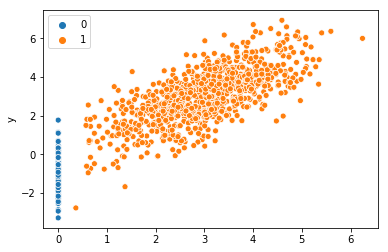

In [25]:
# Inspect
sb.scatterplot(x=make_x_0_if_null(df6['x']), y=df6['y'], hue=create_x_null_ind(df6['x']))

It looks like this made a nice line!

However, does it really matter which value we pick for x?  Let's find out.

In [27]:
def sim_null_x_value(k):
    def impute_x(x, k):
        return [k if np.isnan(a) else a for a in x]
    
    # Fit model
    model6_impute_x = smf.ols(
        formula='y ~ impute_x(x, k) + create_x_null_ind(x)',
        data=df6
    )
    
    return model6_impute_x.fit()

In [46]:
# Sample 10 random and rounded imputation values from -100 to 100.  And sort it for easier inspection.
np.random.seed(666)
mesh = np.rint(np.random.uniform(-100, 100, 10))
mesh = np.sort(mesh)

df_prediction = pd.DataFrame()

for i, k in enumerate(mesh):
    # Generate fit
    loop_model_fit = sim_null_x_value(k)
    
    # Add predictios as a column to the prediction df
    df_prediction[f'impute_{k}'] = loop_model_fit.predict(df6)
    
# Inspect
df_prediction.head()

,impute_-97.0,impute_-90.0,impute_-80.0,impute_-17.0,impute_2.0,impute_35.0,impute_40.0,impute_46.0,impute_69.0,impute_90.0
0,2.257359,2.257359,2.257359,2.257359,2.257359,2.257359,2.257359,2.257359,2.257359,2.257359
1,2.935348,2.935348,2.935348,2.935348,2.935348,2.935348,2.935348,2.935348,2.935348,2.935348
2,3.083411,3.083411,3.083411,3.083411,3.083411,3.083411,3.083411,3.083411,3.083411,3.083411
3,3.163406,3.163406,3.163406,3.163406,3.163406,3.163406,3.163406,3.163406,3.163406,3.163406
4,3.102091,3.102091,3.102091,3.102091,3.102091,3.102091,3.102091,3.102091,3.102091,3.102091


All these predictions look the same.  Do a quick correlation check.

In [47]:
df_prediction.corr()

,impute_-97.0,impute_-90.0,impute_-80.0,impute_-17.0,impute_2.0,impute_35.0,impute_40.0,impute_46.0,impute_69.0,impute_90.0
impute_-97.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_-90.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_-80.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_-17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_35.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_40.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_46.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_69.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_90.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Perfect Pearson correlation, so exactly the same predictions.

If you're confused about this, I encourage you to pick a couple of these potential values, build the regresion, and write out the predictions for some rows to understand what is happening.  tl;dr the regression is picking up on whatever value you use, and imputing `x` to be 0 makes the regression way easier to interpret than non-0 values!

# Data 7

In [48]:
# Read in
df7 = pd.read_csv('../data/df7.csv')

In [49]:
# Inspect
df7.head()

,x,y
0,A,-0.437663
1,NaN,-2.953738
2,A,1.267236
3,B,2.445026
4,B,0.525157


Aha!  Here we happened to see a missig value right off the bat.

Categoricals are much easier when it comes to dealing with missing values.  Missing values never overlap with another value, so we can think of them as just another "level" like the other value.  But generally I like to change them to some string value because not all modelling frameworks support missing values.  Here, let's just change np.NaN to "Missing".

np.NaNs for string columns can be messy because the same logic for numerical varaibles don't apply.  We have a few options:

- Modify our read function to not convert specific values to np.NaN (here it's an empty string)
- Use `.fillna()`

For simplicity we'll just use the latter here.

In [65]:
def make_x_missing_if_null(x):
    return x.fillna('Missing')

In [66]:
# Fit model
model7_x_missing = smf.ols(
    formula='y ~ make_x_missing_if_null(x)',
    data=df7
)
model7_x_missing_fit = model7_x_missing.fit()

In [67]:
# Summarize
model7_x_missing_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1713.
Date:                Wed, 27 May 2020   Prob (F-statistic):          2.96e-323
Time:                        23:00:51   Log-Likelihood:                -1394.0
No. Observations:                1000   AIC:                             2794.
Df Residuals:                     997   BIC:                             2809.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0248      0.047      0.530      0.596      -0.067       0.117
make_x_missing_if_null(x)[T.B]           2.9976      0.065     45.932      0.000       2.870       3.126
make_x_missing_if_null(x)[T.Missing]    -2.1427      0.107    -20.017      0.000      -2.353      -1.933
==============================================================================
Omnibus:                        8.316   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                6.075
Skew:                           0.061   Prob(JB):                       0.0480
Kurtosis:                       2.638   Cond. No.                         4.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""